In [120]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "5"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
isola-h100-1.csail.mit.edu
/vision-nfs/isola/env/akumar01/synthetic-mdps/src


/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


/vision-nfs/isola/env/akumar01/.virtualenvs/smdps/bin/python


In [121]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [122]:
import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState

import optax

In [123]:
dir_data = "/vision-nfs/isola/env/akumar01/synthetic-mdps-data/"

In [124]:
# envs_mujoco = ["Reacher", "InvertedPendulum", "InvertedDoublePendulum", "HalfCheetah", "Hopper", "Walker2d", "Ant", "Humanoid", "HumanoidStandup"]
envs_mujoco = ["Reacher", "InvertedPendulum", "InvertedDoublePendulum", "HalfCheetah", "Hopper", "Walker2d", "Ant"]

In [125]:
data = {
    'Pretraining': [],
    'TestEnv': [],
    'Loss': [],
    'Return': []
}
for env in envs_mujoco:
    try:
        with open(f"{dir_data}/icl_train/{env}_oracle/metrics_before.pkl", "rb") as f:
            a = jax.tree.map(lambda x: np.array(x), pickle.load(f))
        data['Pretraining'].append('scratch')
        data['TestEnv'].append(env)
        data['Loss'].append(a['loss'].mean())
        data['Return'].append(a['rets'].mean())
        with open(f"{dir_data}/icl_train/{env}_oracle/metrics_after.pkl", "rb") as f:
            a = jax.tree.map(lambda x: np.array(x), pickle.load(f))
        data['Pretraining'].append('oracle')
        data['TestEnv'].append(env)
        data['Loss'].append(a['loss'].mean())
        data['Return'].append(a['rets'].mean())
        with open(f"{dir_data}/icl_train/{env}_oracle_aug/metrics_after.pkl", "rb") as f:
            a = jax.tree.map(lambda x: np.array(x), pickle.load(f))
        data['Pretraining'].append('oracle_aug')
        data['TestEnv'].append(env)
        data['Loss'].append(a['loss'].mean())
        data['Return'].append(a['rets'].mean())
    except:
        pass
df = pd.DataFrame(data)
df

,Pretraining,TestEnv,Loss,Return
0,scratch,Reacher,0.968687,-11.708245
1,oracle,Reacher,0.000157,-3.819891
2,oracle_aug,Reacher,0.185687,-4.489075
3,scratch,InvertedPendulum,0.999842,3.000000
4,oracle,InvertedPendulum,0.000052,1000.000000
5,oracle_aug,InvertedPendulum,0.026737,1000.000000
6,scratch,InvertedDoublePendulum,1.088655,96.214310
7,oracle,InvertedDoublePendulum,0.000458,9354.601212
8,oracle_aug,InvertedDoublePendulum,0.165503,195.126340
9,scratch,HalfCheetah,1.017001,-67.340630


In [126]:
df.pivot(index='Pretraining', columns='TestEnv', values='Return')

TestEnv,Ant,HalfCheetah,Hopper,InvertedDoublePendulum,InvertedPendulum,Reacher,Walker2d
Pretraining,,,,,,,
oracle,3956.488300,5467.914833,2059.988815,9354.601212,1000.0,-3.819891,5403.983791
oracle_aug,950.145431,2720.375824,218.684151,195.126340,1000.0,-4.489075,441.571858
scratch,761.742749,-67.340630,0.028791,96.214310,3.0,-11.708245,95.243330


In [127]:
a = df.pivot(index='Pretraining', columns='TestEnv', values='Return')
upper, lower = a.loc['oracle'], a.loc['scratch']
df['upper'] = upper.loc[df['TestEnv']].to_numpy()
df['lower'] = lower.loc[df['TestEnv']].to_numpy()
df['NormalizedReturn'] = (df['Return']-df['lower'])/(df['upper']-df['lower'])

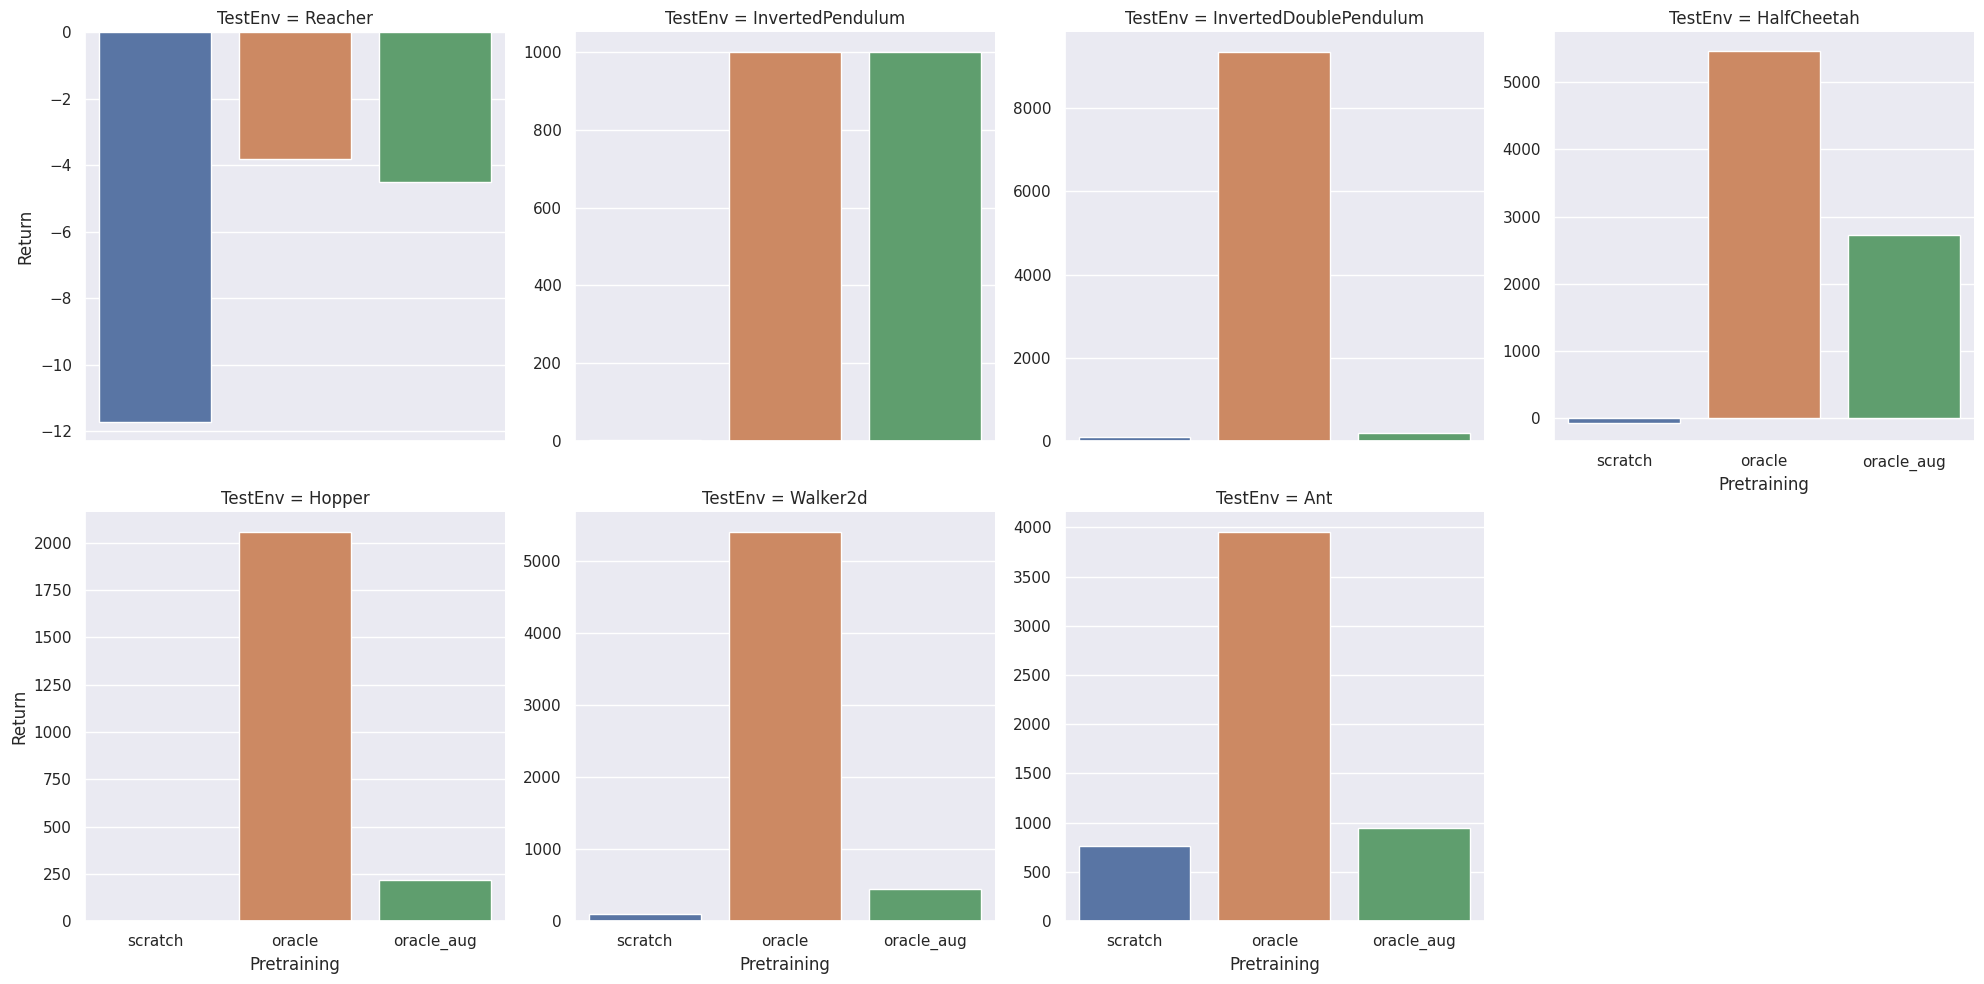

In [129]:
sns.catplot(data=df, x='Pretraining', y='Return', kind="bar", col='TestEnv', col_wrap=4, hue="Pretraining", sharey=False)

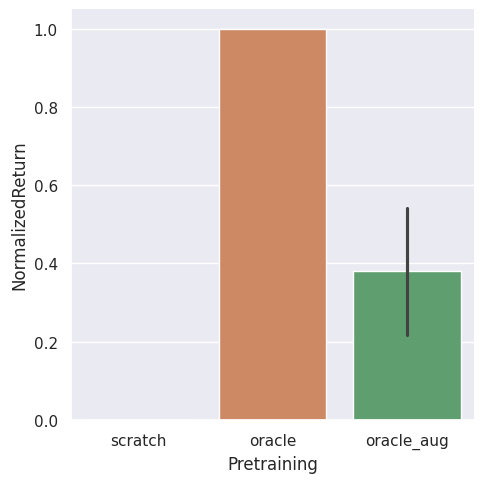

In [134]:
sns.catplot(data=df, x='Pretraining', y='NormalizedReturn', kind="bar", hue="Pretraining", errorbar=('se', 1.))

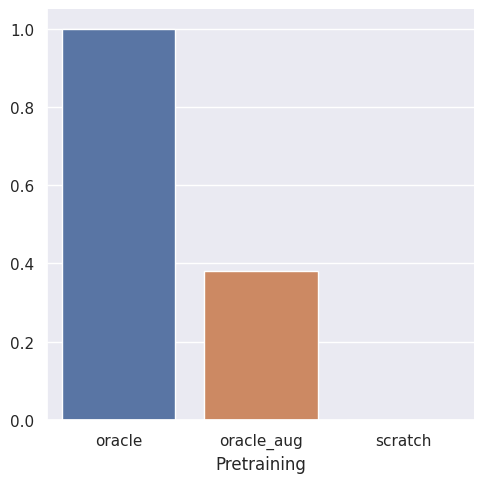

In [27]:
a = df.pivot(index='Pretraining', columns='TestEnv', values='NormalizedReturn').mean(axis=1)
# sns.catplot(data=a, kind="bar", hue=a.index)
sns.catplot(x=a.index, y=a.values, kind='bar', hue=a.index)

In [111]:
with open("/vision-nfs/isola/env/akumar01/synthetic-mdps-data/temp/csmdp/rets_train.pkl", "rb") as f:
    a = pickle.load(f)
df = pd.DataFrame(a).T

In [112]:
df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,-6.502972,15.040921,-1.880490,-9.936020,2.846055,1.474305,3.573270,1.312932,-13.699976,8.814011,...,-4.191244,0.344719,-10.245337,35.459705,-2.255260,-8.198369,77.537796,5.584847,-22.056063,70.334641
1,-3.992263,26.035004,2.630036,-11.251588,4.229982,1.189525,10.023714,0.136752,-11.646237,9.963139,...,-7.551313,0.389007,-12.716383,48.086773,-4.616920,-15.531517,92.859558,7.318928,-21.613735,82.029121
2,-6.189260,17.020317,-0.625783,-10.230042,4.419254,3.168363,8.088915,-0.134355,-11.702636,10.615231,...,-6.873537,0.545502,-8.308290,48.787537,-3.566428,-10.711180,96.093834,10.690768,-26.366573,81.677292
3,-8.828253,19.458174,0.234620,-8.547576,5.430658,3.050451,2.987031,0.681745,-10.403436,10.144901,...,-3.555533,0.376337,-9.536273,69.231667,-3.569190,-8.055202,99.618103,10.937193,-22.958218,84.186447
4,-8.217764,27.474632,-0.153844,-11.256466,5.285131,3.414316,8.312411,-0.424860,-8.895960,10.605064,...,-5.028807,0.612122,-8.554779,90.411194,-4.211885,-8.697543,105.634354,13.187302,-24.194473,81.865059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-2.627203,56.002972,8.199113,-5.207355,9.876444,5.425715,15.731141,7.538620,-6.063640,14.813324,...,-0.601495,3.779912,5.387104,132.391571,3.602387,3.738402,147.881729,39.342522,-7.416295,89.063278
96,-1.993032,47.643997,5.649266,-5.333108,10.067081,7.416261,14.308775,4.846914,-6.823302,13.545530,...,0.263327,1.481369,4.454588,129.165863,1.471217,6.464692,129.178818,37.814247,-5.888225,89.668549
97,-1.886097,44.880043,9.112751,-6.162228,10.139027,12.523617,15.574270,8.375421,-5.696499,13.687423,...,-0.673859,2.369239,3.502831,121.209183,2.174904,6.835181,143.710541,40.594009,-10.056053,87.545578
98,-4.158720,50.332088,7.465018,-6.269266,11.993006,11.326046,11.868765,5.386895,-3.343064,12.096193,...,-2.112022,4.172851,3.637352,121.895752,2.035174,4.380250,133.170593,41.373772,-10.275293,90.104156


In [114]:
df = df.reset_index().melt(id_vars=['index'], var_name='EnvSeed', value_name='Return')
df = df.rename(columns={'index': 'time'})

In [115]:
df

,time,EnvSeed,Return
0,0,0,-6.502972
1,1,0,-3.992263
2,2,0,-6.189260
3,3,0,-8.828253
4,4,0,-8.217764
...,...,...,...
102395,95,1023,89.063278
102396,96,1023,89.668549
102397,97,1023,87.545578
102398,98,1023,90.104156


<Axes: xlabel='time', ylabel='Return'>

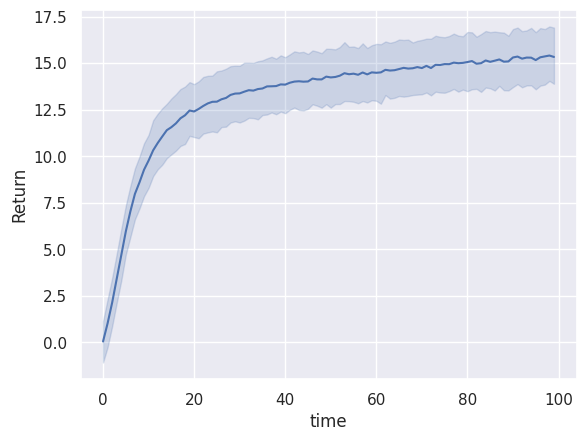

In [116]:
sns.lineplot(df, x='time', y='Return')